# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


In [163]:
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import mean_absolute_error, median_absolute_error
# ------- LIBARRY functions ---------
import numpy as np
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMAResults
# LIBRARY
from seaborn import histplot, relplot, lineplot
from pandas import Series
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

def plot_series_hist_acf_kpss(data: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    f = relplot(data=data, kind='line', markers=True, height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(data, lags=lags)
    plt.show()

    ax = histplot(data, bins=hist_bins, kde=True)
    plt.show()

    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
    kpss_stat = kpss(data, store=True)    # hypothesis: constant
    print("KPSS={}".format(kpss_stat))# around a mean

    # Compare median and mean
    print(data.describe())

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=data, lag=lags)
        plt.show()

# Actual vs Fitted
def plot_actual_and_fitted_values(y: Series, model_fit: ARIMAResults):
    fitted_ = model_fit.fittedvalues[y.index]
    f, axes = plt.subplots(1, 1)
    f.set_size_inches(w=20, h=10)
    f = lineplot(data=pd.DataFrame({'actual': y, 'fitted': fitted_}), ax=axes)
    plt.show()


def errors(y: Series, y_pred: Series):
    diff_ = (y - y_pred)
    return {
        'RMSE': np.sqrt(mean_squared_error(y, y_pred, squared=True)),
        'MAPE': mean_absolute_percentage_error(y, y_pred),
        'MAE': mean_absolute_error(y, y_pred),
        'MEDIAN_AE': median_absolute_error(y, y_pred),
        'MAX_ABS': diff_.abs().max(),
        'MIN_ABS': diff_.abs().min()}

def model_errors_precalculated(res: RegressionResults):
    return {
        'RMSE / standard error (SE)': np.sqrt(res.mse_resid),  # https://otexts.com/fpp3/least-squares.html#standard-error-of-the-regression
        'RSQUARED': res.rsquared
    }


def model_errors(y: Series, model_fit: ARIMAResults):
    fitted:Series = model_fit.fittedvalues[y.index]
    return errors(y, fitted)

# Preprocessing
Feature engineering, create categorial columns

In [164]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': float, 'Promo': float, 'SchoolHoliday': float})

# get data for one store
df_train = df_train.groupby(by='Store').get_group(2).set_index('Date').sort_index()
# FEATURE ENGINEERING
## StateHoliday -> categorial
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')
## StateHoliday -> dummy variable
df_train = pd.concat([df_train, pd.get_dummies(df_train['StateHoliday'], prefix='StateHoliday', dtype=float)], axis=1)
#df_train.groupby(by=['StateHoliday']).get_group('a')

## Day of week -> categorial
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')
df_train = pd.concat([df_train, pd.get_dummies(df_train['DayOfWeek'], prefix='DayOfWeek', dtype=float)], axis=1)

df_train['Month'] = df_train.index.month

dummies = pd.get_dummies(df_train['Month'], prefix='Month', dtype=float)
df_train = pd.concat([df_train, dummies], axis=1)

df_train.info()
df_train.head(5)

X = df_train[['Open',
              'Promo',
              'SchoolHoliday',
              'StateHoliday_0',
              'StateHoliday_a',
              'StateHoliday_b',
              'StateHoliday_c',
              'DayOfWeek_1',
              'DayOfWeek_2',
              'DayOfWeek_3',
              'DayOfWeek_4',
              'DayOfWeek_5',
              'DayOfWeek_6',
              'DayOfWeek_7',
              'Month_1',
              'Month_2',
              'Month_3',
              'Month_4',
              'Month_5',
              'Month_6',
              'Month_7',
              'Month_8',
              'Month_9',
              'Month_10',
              'Month_11',
              'Month_12']].astype('float')
Y = df_train['Sales'].astype('float')

X.info()
X.head(5)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Store           942 non-null    int64   
 1   DayOfWeek       942 non-null    category
 2   Sales           942 non-null    int64   
 3   Customers       942 non-null    int64   
 4   Open            942 non-null    float64 
 5   Promo           942 non-null    float64 
 6   StateHoliday    942 non-null    category
 7   SchoolHoliday   942 non-null    float64 
 8   StateHoliday_0  942 non-null    float64 
 9   StateHoliday_a  942 non-null    float64 
 10  StateHoliday_b  942 non-null    float64 
 11  StateHoliday_c  942 non-null    float64 
 12  DayOfWeek_1     942 non-null    float64 
 13  DayOfWeek_2     942 non-null    float64 
 14  DayOfWeek_3     942 non-null    float64 
 15  DayOfWeek_4     942 non-null    float64 
 16  DayOfWeek_5     942 non-null    float64 
 1

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StateHoliday_0,StateHoliday_a,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2,2,0,0,0.0,0.0,a,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,2,3,4422,650,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,2,4,4159,555,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,2,5,4484,574,1.0,0.0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,2,6,2342,324,1.0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            942 non-null    float64
 1   Promo           942 non-null    float64
 2   SchoolHoliday   942 non-null    float64
 3   StateHoliday_0  942 non-null    float64
 4   StateHoliday_a  942 non-null    float64
 5   StateHoliday_b  942 non-null    float64
 6   StateHoliday_c  942 non-null    float64
 7   DayOfWeek_1     942 non-null    float64
 8   DayOfWeek_2     942 non-null    float64
 9   DayOfWeek_3     942 non-null    float64
 10  DayOfWeek_4     942 non-null    float64
 11  DayOfWeek_5     942 non-null    float64
 12  DayOfWeek_6     942 non-null    float64
 13  DayOfWeek_7     942 non-null    float64
 14  Month_1         942 non-null    float64
 15  Month_2         942 non-null    float64
 16  Month_3         942 non-null    float64
 17  Month_4         

,Open,Promo,SchoolHoliday,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-02,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-03,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-04,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-01-05,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


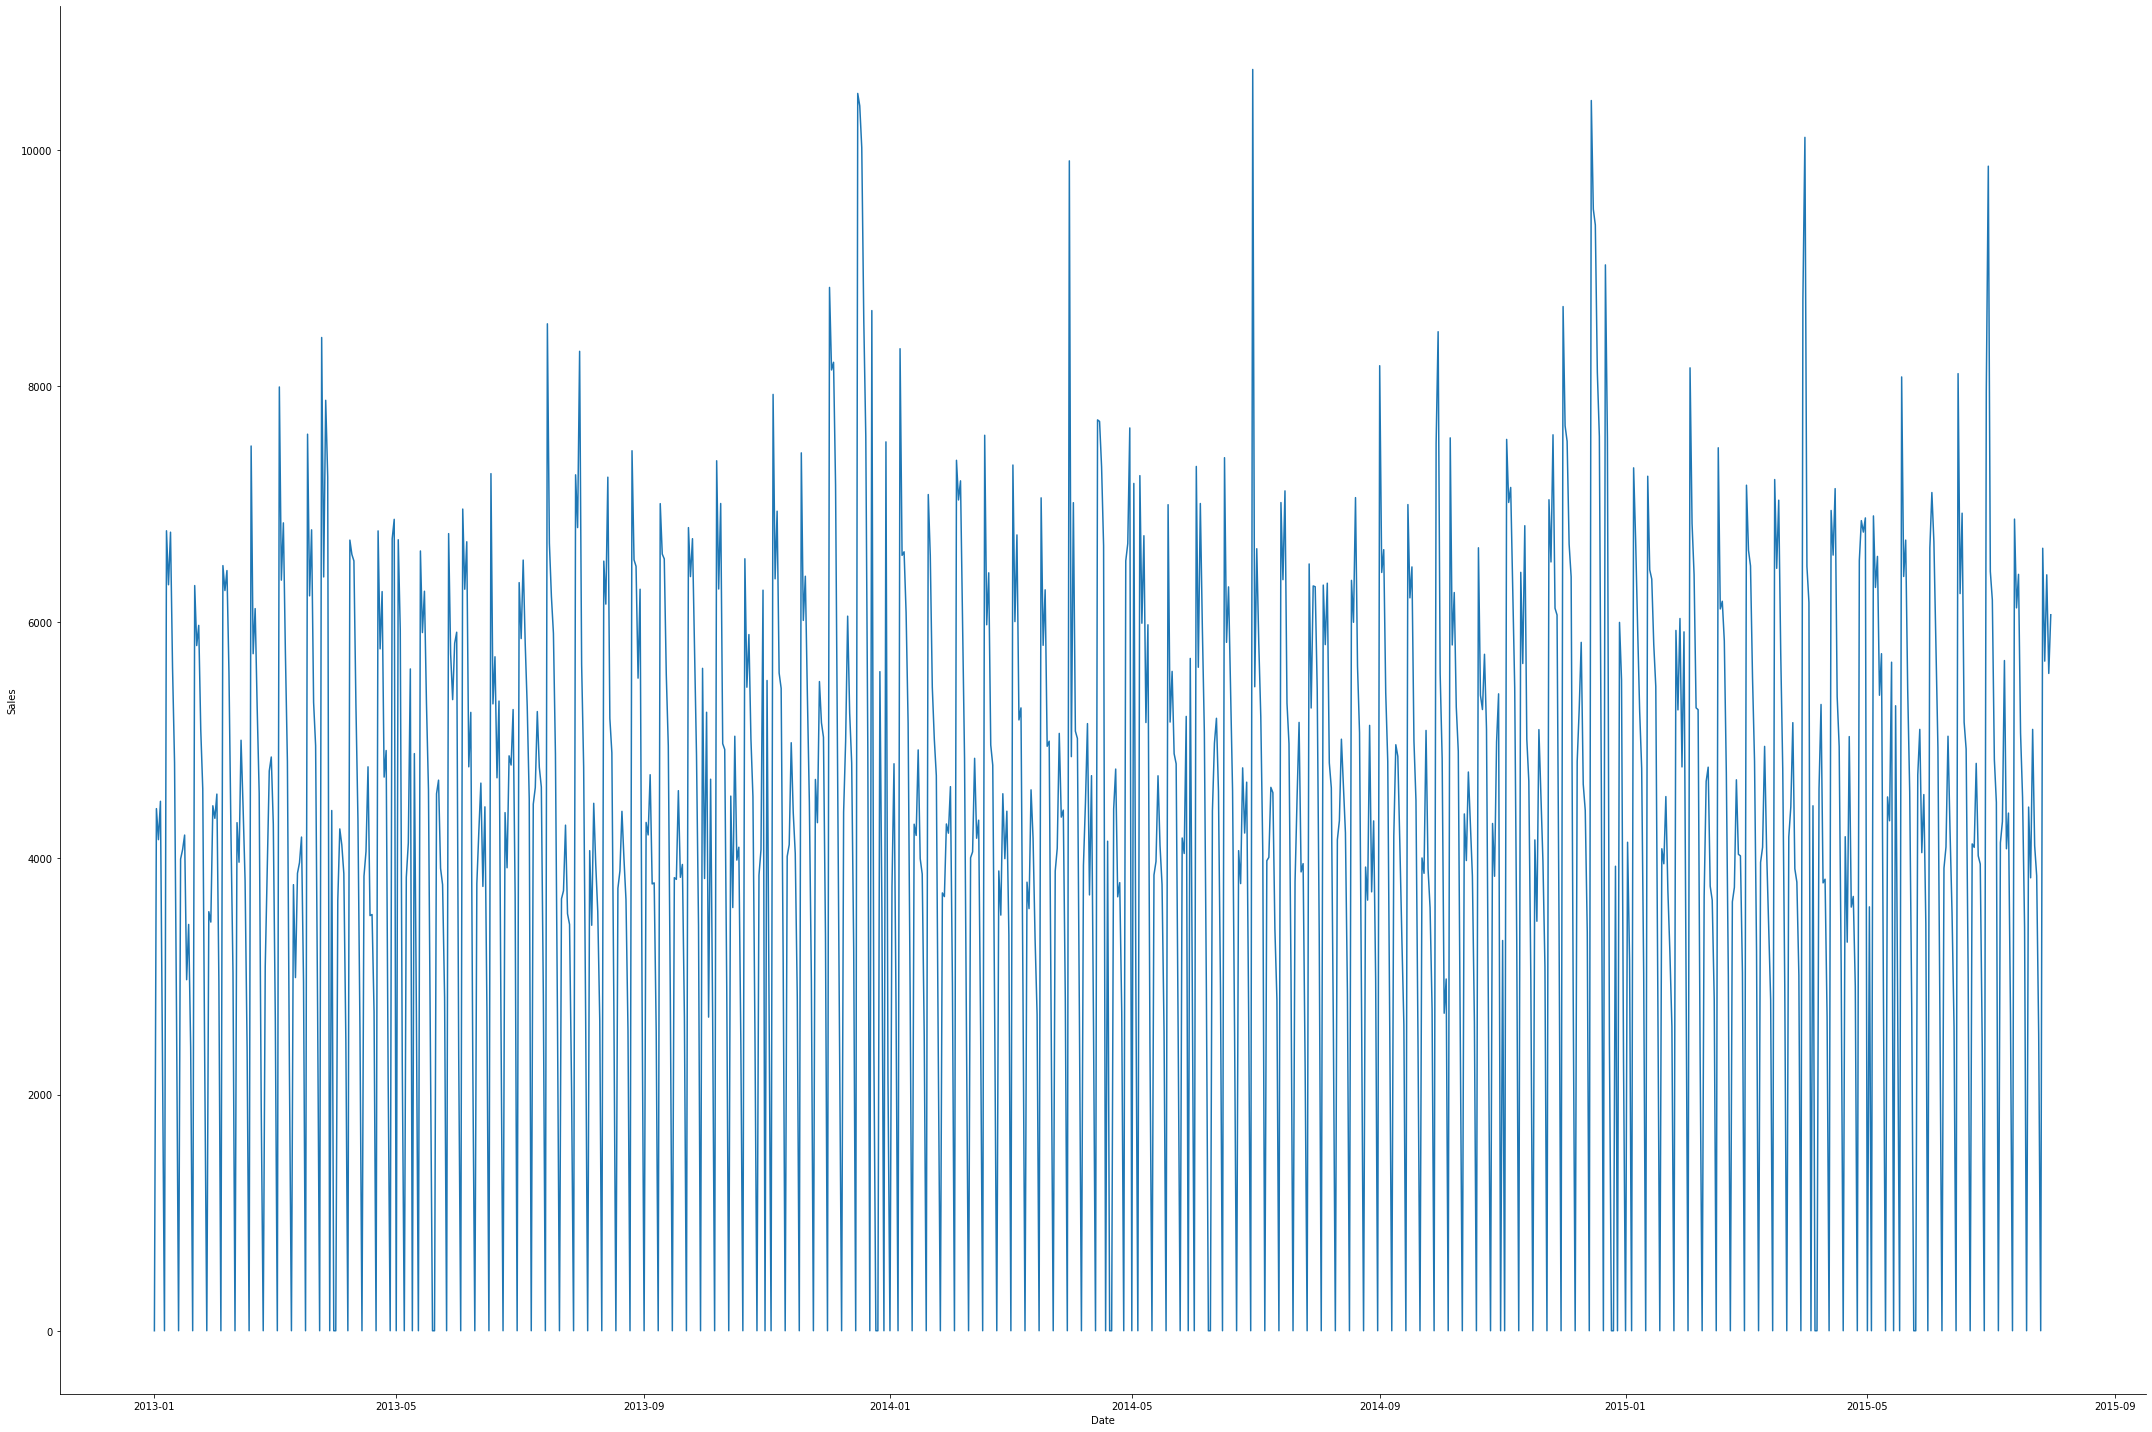

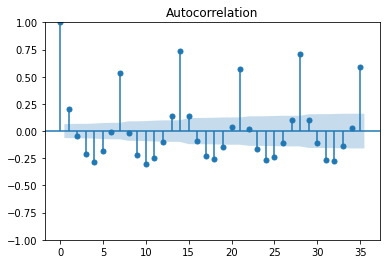

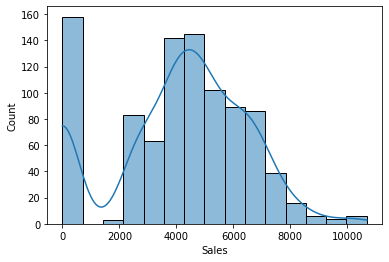

KPSS=(0.30030540241246695, 0.1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7f56b10c8130>)
count      942.000000
mean      4122.991507
std       2363.628674
min          0.000000
25%       2806.750000
50%       4395.500000
75%       5804.500000
max      10682.000000
Name: Sales, dtype: float64


/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [165]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

plot_series_hist_acf_kpss(Y, lags=35)

# Forecast | Oridinary least squares
Naively assume we can forecast by OLS and interpret the residuals of the model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     411.9
Date:                Sat, 27 Nov 2021   Prob (F-statistic):               0.00
Time:                        13:46:13   Log-Likelihood:                -7510.6
No. Observations:                 942   AIC:                         1.507e+04
Df Residuals:                     918   BIC:                         1.519e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Open            3154.5099    439.183      7.183      0.000    2292.591    4016.429
Promo           1933.8647     55.536     34.822      0.000    1824.873    2042.857
SchoolHoliday     97.4086     73.578      1.324      0.186     -46.993     241.810
StateHoliday_0  1109.7952    351.911      3.154      0.002     419.151    1800.440
StateHoliday_a  -439.6073    179.690     -2.446      0.015    -792.259     -86.956
StateHoliday_b -1044.3011    286.288     -3.648      0.000   -1606.156    -482.446
StateHoliday_c  -970.8390    342.025     -2.839      0.005   -1642.081    -299.597
DayOfWeek_1      804.3554    107.938      7.452      0.000     592.521    1016.190
DayOfWeek_2      165.2485    110.336      1.498      0.135     -51.291     381.788
DayOfWeek_3      626.7215    108.956      5.752      0.000     412.889     840.554
DayOfWeek_4     -216.5620    106.321     -2.037      0.042    -425.223      -7.901
DayOfWeek_5     -481.7888    109.924     -4.383      0.000    -697.521    -266.057
DayOfWeek_6    -1256.7898    110.157    -11.409      0.000   -1472.978   -1040.601
DayOfWeek_7     -986.1370    363.964     -2.709      0.007   -1700.436    -271.838
Month_1         -346.4202     75.370     -4.596      0.000    -494.337    -198.503
Month_2         -286.2400     80.049     -3.576      0.000    -443.341    -129.139
Month_3          -82.5118     75.897     -1.087      0.277    -231.464      66.441
Month_4         -181.6037     76.730     -2.367      0.018    -332.191     -31.017
Month_5         -178.6313     75.361     -2.370      0.018    -326.531     -30.732
Month_6         -107.9380     77.187     -1.398      0.162    -259.422      43.546
Month_7         -203.8686     80.170     -2.543      0.011    -361.205     -46.532
Month_8         -364.8753     99.182     -3.679      0.000    -559.526    -170.225
Month_9         -202.1991     91.893     -2.200      0.028    -382.543     -21.855
Month_10        -338.0488     93.390     -3.620      0.000    -521.332    -154.766
Month_11           1.9063     91.856      0.021      0.983    -178.365     182.178
Month_12         945.4782     89.382     10.578      0.000     770.062    1120.894
==============================================================================
Omnibus:                      165.277   Durbin-Watson:                   1.619
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1248.948
Skew:                           0.572   Prob(JB):                    6.23e-272
Kurtosis:                       8.524   Cond. No.                     7.02e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.16e-29. This might indicate that there are
strong multicollinearity p

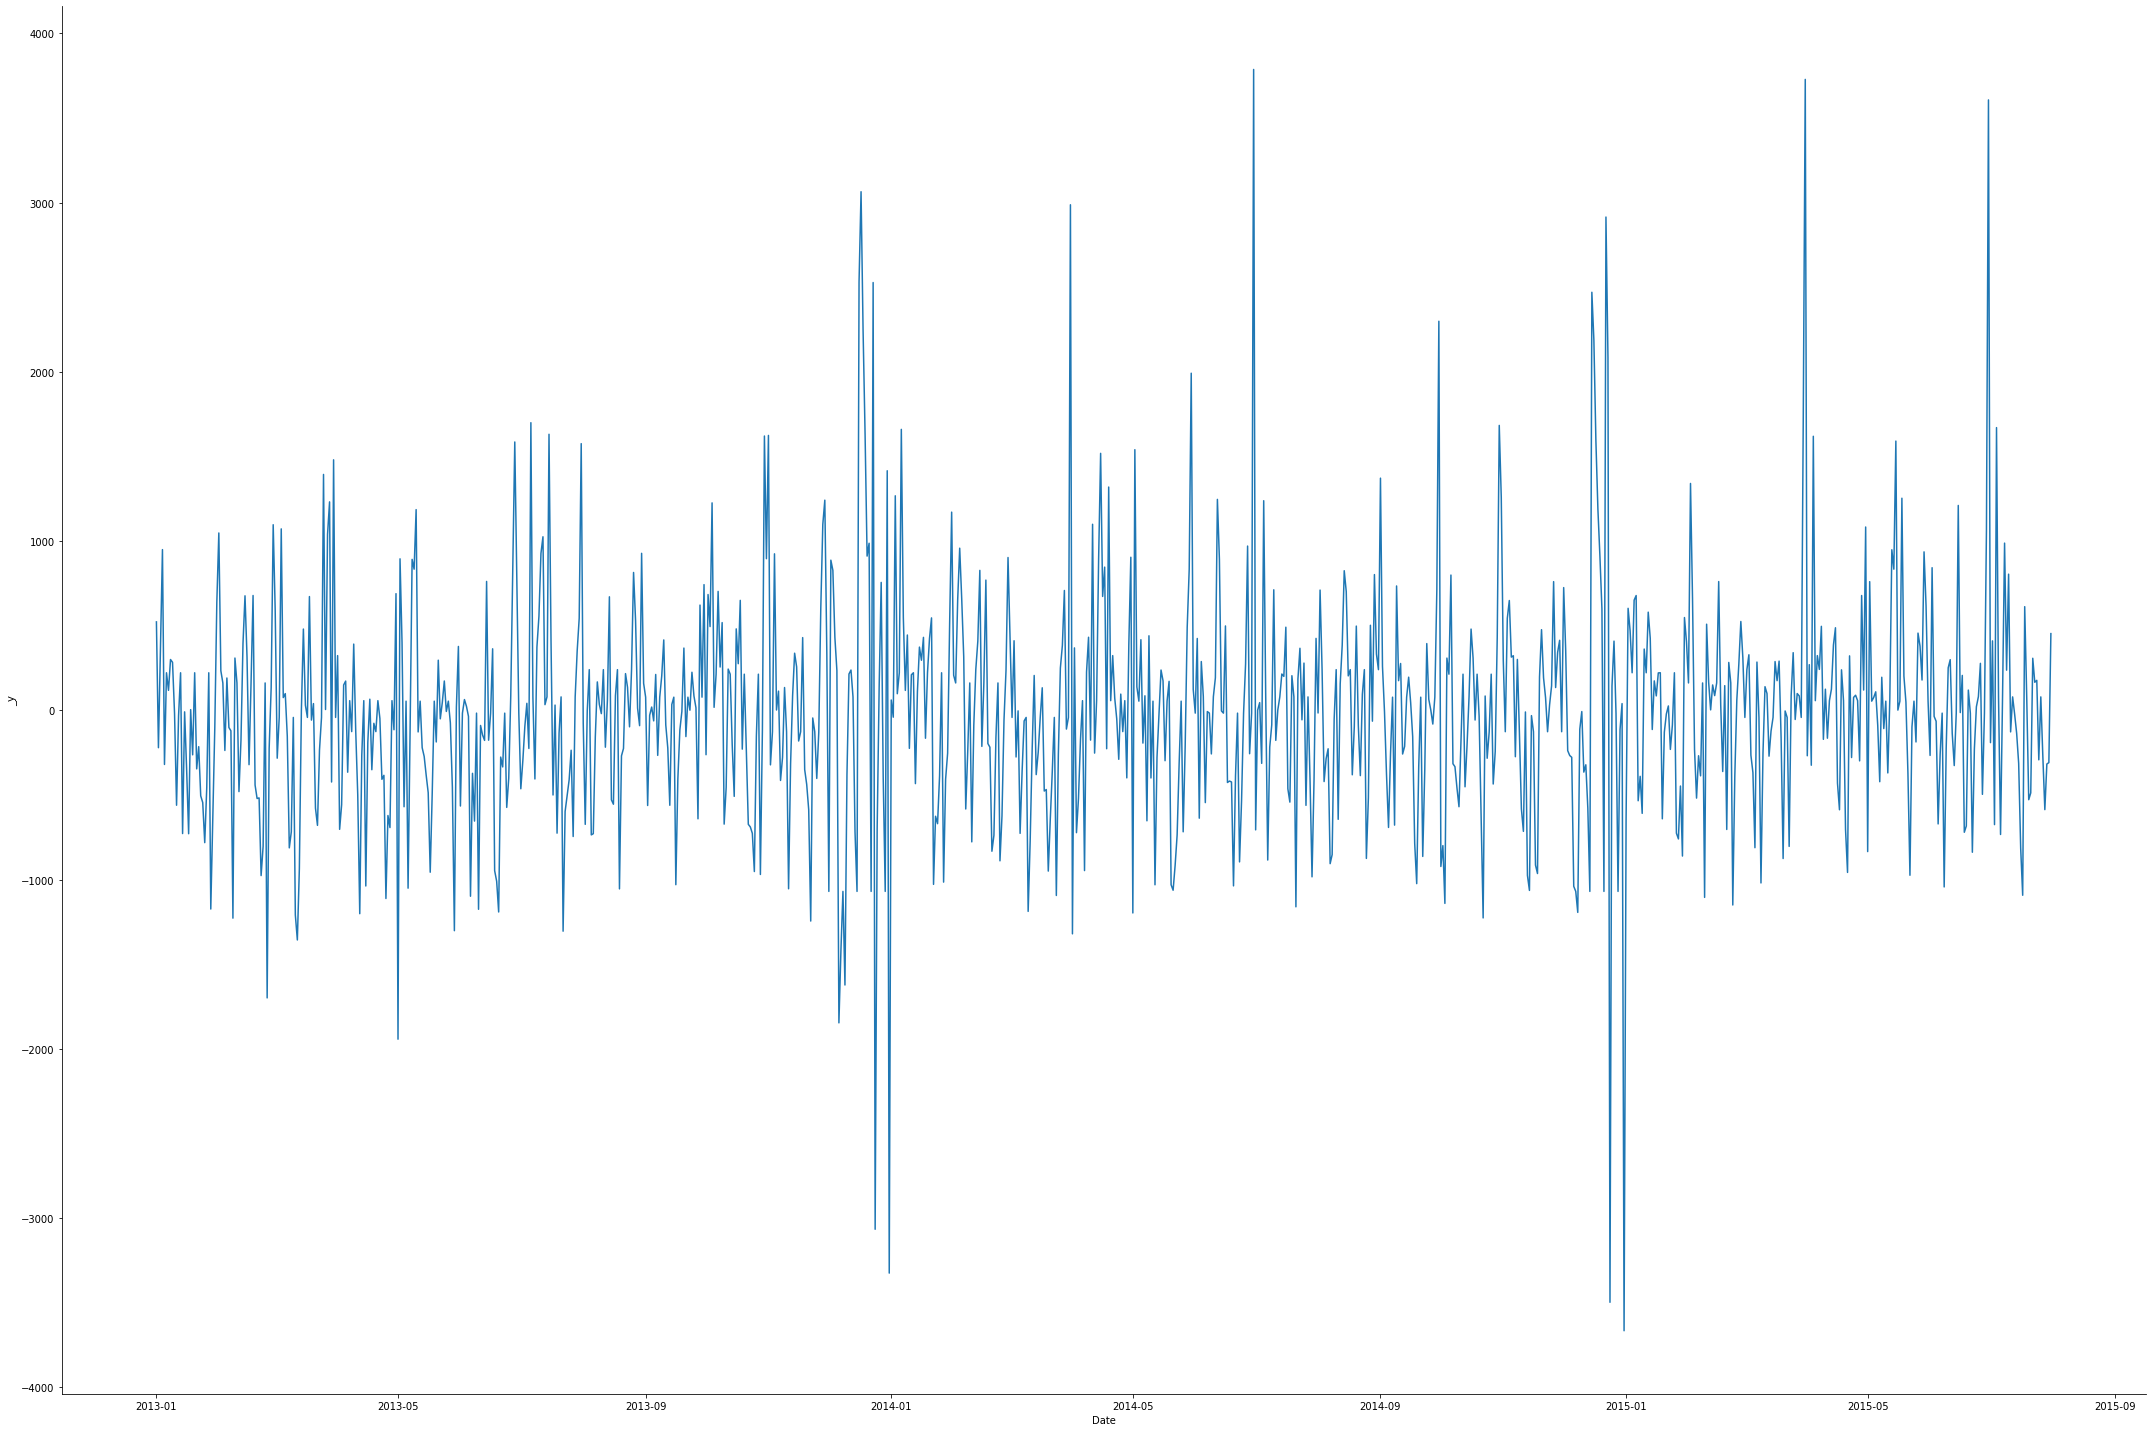

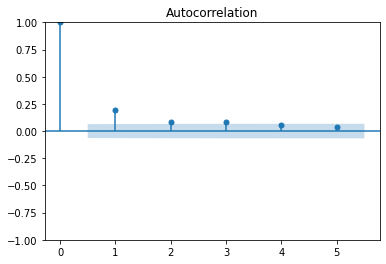

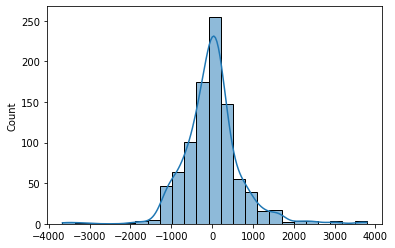

/usr/local/src/git/github/bruennijs/kaggle_rossmann_sales_prediction/venv/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KPSS=(0.24995782395233127, 0.1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}, <statsmodels.stats.diagnostic.ResultsStore object at 0x7f56add8edf0>)
count    9.420000e+02
mean     2.846854e-11
std      7.025164e+02
min     -3.664913e+03
25%     -3.665500e+02
50%     -5.714025e+00
75%      2.681356e+02
max      3.787413e+03
dtype: float64


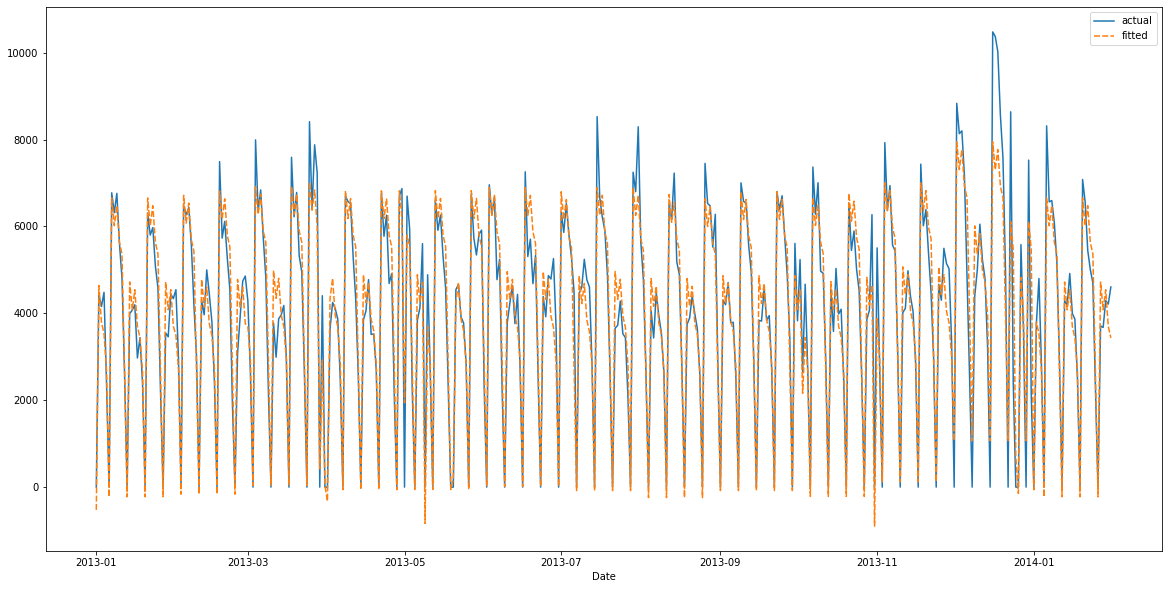

"Errors (precalculated) | {'RMSE / standard error (SE)': 711.2625108900819, 'RSQUARED': 0.9116606102170051}"

In [166]:
from statsmodels.regression.linear_model import OLS, RegressionResults

model: OLS = OLS(endog=Y, exog=X)
model_fit: RegressionResults = model.fit(disp=False)

model_fit.summary()
#model_fit.pvalues.to_dict()

plot_series_hist_acf_kpss(model_fit.resid, hist_bins=25)

plot_actual_and_fitted_values(Y['2013-01':'2014-01'], model_fit)

#model_errors(Y, model_fit)

'Errors (precalculated) | {}'.format(model_errors_precalculated(model_fit))